In [75]:
# For neural net
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# General
import numpy as np
import random
import math
import time
from prettytable import PrettyTable


# For text
import re
import string

In [10]:
def create_joke_data(jokes : list, block_size : int=2, special_character : str='.'):
    """
    Takes words list and breaks into training samples based on the desired model-type. For example,
    a bigram model where n=2 or a trigram model where n=3. 
    Returns words (the vocabulary of the model), xs, and ys (inputs and labels).
    """
    # Create list of all words used in the jokes
    words = set(' '.join([j for j in jokes]).split(' '))
    words = [w for w in words if w != ""] ##remove empty string
    # Init dicts
    itow = {i+1 : w for i, w in enumerate(sorted(words))}
    itow[0] = special_character
    wtoi = {w : i for i, w in itow.items()}
    n = block_size + 1

    # Create samples
    X, Y = [], []
    for j in jokes:
        context = [0] * block_size
        word_bag = j.split(' ') + [special_character]  ##add special end characters
        word_bag = [w for w in word_bag if w != ""] ##remove any blank strings that get created
        for w in word_bag:
            ix = wtoi[w]
            X.append(context)
            Y.append(ix)
            # print([itow[c] for c in context], [itow[ix]])

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
        
    n_samples = X.shape[0]
    print(f"{ n_samples = }")

    
    return words, X, Y


In [11]:

def split_samples(inputs, labels, frac=0.8, seed=123):
    """Split xs and ys (inputs and labels) into train and test sets"""
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [12]:
class JokeGramMLP:

    def __init__(self, words : list, block_size : int, special_character : str):
        """
        An instance of an MLP where 'block_size' defines the number of characters used 
        to predict the next character (the block size or context).
        """
        self.n_inputs = block_size ##the number of inputs (ie, excluding the label)
        self.special_char = special_character
        # Init dicts
        self.itow = {i+1 : w for i, w in enumerate(sorted(words))}
        self.itow[0] = special_character
        self.wtoi = {w : i for i, w in self.itow.items()}

        self.n_outputs = int(len(self.itow))
        
         
    def initialize_weights(self,
                           embedding_dimensions=2,
                           hidden_layer_neurons=100, 
                           generator=None):
        "Randomly initialize the model's weights."
        self.hl_neurons = hidden_layer_neurons
        self.emb_dim = embedding_dimensions

        # INITALIZE NETWORK WEIGHTS
        n_inputs = self.n_inputs          ##number of inputs per sample (the block size)
        words = self.n_outputs            ##number of words in vocab
        emb_dim = embedding_dimensions    ##dimensions of embedding space
        hl_neurons = hidden_layer_neurons ##number of neurons in hidden layer


        self.C = torch.randn((words, emb_dim), generator=generator, requires_grad=True)

        # self.W1 = torch.randn((emb_dim*n_inputs, hl_neurons), generator=generator, requires_grad=True)
        self.W1 = self._xavier_init(emb_dim*n_inputs, hl_neurons, generator, requires_grad=True)
        self.b1 = torch.zeros(hl_neurons, requires_grad=True)

        # self.W2 = torch.randn((hl_neurons, words), generator=generator, requires_grad=True)
        self.W2 = self._xavier_init(hl_neurons, words, generator, requires_grad=True)
        self.b2 = torch.zeros(words, requires_grad=True)

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad=True
        print(f"Model params = { sum(p.nelement() for p in self.parameters) }")

    def _xavier_init(self, n_inputs, n_neurons, generator=None, requires_grad=False):
        """My implementation of xavier-normal weight initialization for tanh layers"""
        with torch.no_grad():
            lower, upper = -(1.0 / math.sqrt(n_inputs)), (1.0 / math.sqrt(n_inputs))
            W = lower + torch.rand((n_inputs, n_neurons), generator=generator) * (upper - lower)
        W.requires_grad = requires_grad
        return W


    def forward_pass(self, xs, ys=None, regularization=0):
        "Perform a forward pass of the inputs (xs) through the network. If ys are provided, loss will be evaluated."
        # forward pass
        n_samples = xs.shape[0]
        n_inputs = self.n_inputs
        hl_neurons = self.hl_neurons
        emb_dim = self.emb_dim

        parameters = self.parameters

        assert n_inputs == xs.shape[1], f"n_inputs ({n_inputs}) does not match the xs.shape[1]"

        # Forward pass
        emb = self.C[xs]
        h = torch.tanh( emb.view(-1, n_inputs*emb_dim) @ self.W1 + self.b1 )   
        logits = h @ self.W2 + self.b2
        # predicted probabilities
        probs = F.softmax(logits, dim=1)

        # loss
        loss = None
        if ys is not None: #eval loss
            loss = F.cross_entropy(logits, ys)
            if regularization > 0.0:       
                for p in self.parameters:
                    loss += regularization*(p**2).mean()
            self.loss = loss
        
        return probs, loss
                

    def backprop_update(self, lr=0.1):
        "Gradient descent - backpropogate the network and apply a fraction of the gradients to the current weights."
        # backward pass
        for p in self.parameters:
            p.grad = None ##zero the gradient

        self.loss.backward() ##backprop

        # update params
        for p in self.parameters:
            p.data += -lr * p.grad ##learning rate


    def generate_jokes(self, n_words, start_words: str = "", min_length=0, generator=None):
        """
        Generates n_words word examples by passing n-1 random characters into the model, performing a forward pass,
        and probabilistically choosing a character using the model's predicted probability distribution.
        Pass n-2 start_chrs to specify the starting characters of the word generation process (first character is always '.').
        Specify a minimum word length min_length to generate words at least that long.
        """
        itow = self.itow
        wtoi = self.wtoi
        n_inputs = self.n_inputs
        out_jokes = []

        for _ in range(n_words):
            joke = self.special_char #start with special character
            context = [0] * n_inputs 
            
            assert len(start_words.split()) <= n_inputs, f"Number of start words ({len(start_words.split())}) should be {n_inputs} or less."
            for w in start_words.split():
                assert w in wtoi, f"Start word '{w}' cannot be used since it is not in the list of training words."
                joke += " " + w.lower()
                context[1:] + [wtoi[w.lower()]]

            while True:
                # forward pass
                probs, loss = self.forward_pass(
                    torch.tensor([context]) #.reshape(1, n_inputs)
                    )
                # Get word
                word_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
                # determine how to proceed
                if (word_ix==0) & (len(joke.split())-1 <= min_length): ##if the ix is 0 but the joke is too short, resample (-1 due to starting .)
                    pass
                elif (word_ix==0) & (len(joke.split())-1 > min_length): ##if the ix is 0 and joke is long enough, end joke and break joke creation
                    joke += " " + itow[word_ix] ##ends with special char
                    break
                else:                                   ##otherwise, add to the joke and shift the context for the next forward pass
                    joke += " " + itow[word_ix]
                    ## Shift words to predict the next one
                    context = context[1:] + [word_ix] ##shift and append  
                    
            joke = re.sub(r'(\d)\s+(\d)', r'\1\2', joke) ##concatenate sequential numbers
            out_jokes.append(joke)    
        
        return out_jokes

# Training
## Data

In [125]:
# Read in text file - one joke per line
with open('jokes.txt') as f:
    jokes = f.read().splitlines()

In [126]:
N = 3 ## Number of words used to predict the next word
SPECIAL = '.' ## Special character to use for start/stop/padding

In [127]:
# Create dataset based on N and split into training and development sets
words, X, Y = create_joke_data(jokes, N, special_character=SPECIAL)
Xtr, Ytr, Xdev, Ydev = split_samples(X, Y, 0.8, seed=123)

print(f"{len(words) = }")

 n_samples = 29227
len(words) = 4339


## Model Initialization

In [128]:
# Initialize the joke model based on N and provide with list of words in data. Initialize weights based on desired model structure
g = torch.Generator().manual_seed(123)

model = JokeGramMLP(words=words, block_size=N, special_character=SPECIAL)
model.initialize_weights(embedding_dimensions=33,
                         hidden_layer_neurons=128, 
                         generator=g)


Model params = 715880


## Hyperparameter tuning

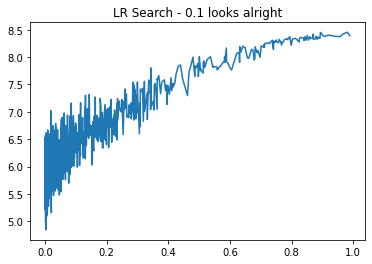

In [129]:
# LR Random Search (randomly sample from within range and try each lr)
lre = [random.uniform(-3, 0) for _ in range(1000)] #torch.linspace(-3, 0, 1000)
lrs = [10**lr for lr in lre] #10**lre
lrs = sorted(lrs, reverse=True)

# lr_losses = [] ##save lrs to this list (dont overwrite)

plt.plot(lrs, lr_losses) #[math.log10(l) for l in lr_losses])
plt.title("LR Search - 0.1 looks alright")
plt.show()

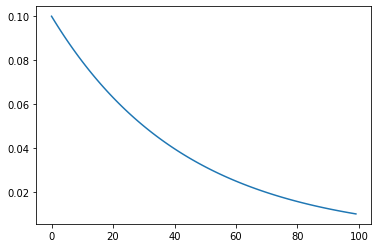

In [130]:
# LR schedule
lr = 0.1
decay = 0.1
epochs = 100
lr_decay = []
for ep in range(epochs):
    lr_new = lr * decay ** (ep / epochs)
    lr_decay.append(lr_new)


plt.plot(lr_decay)
plt.show()

## Training

In [131]:
# Initialzie lists to store metrics
losses, val_losses = [],[]

In [132]:
# TRAIN
epochs = 100
batch_size = 64
print(f"steps per epoch = {Xtr.shape[0] // batch_size}")

for ep in range(epochs):
    # minibatching
    ## batch_ix = torch.randint(0, Xtr.shape[0], (batch_size, )) ##n_samples randints between 0 and length of data
    permutation = torch.randperm(Xtr.shape[0]) 
    batch_losses = []

    strt = time.time()
    for k in range(0, Xtr.shape[0], batch_size):
        batch_ix = permutation[k : k+batch_size]

        # forward pass
        probs, loss = model.forward_pass(Xtr[batch_ix], Ytr[batch_ix], regularization=0.01)
        batch_losses.append(loss.item())
        
        # backward pass + update
        lr = 0.1 #lrs[k]
        decay = 0.1 #set to 1 for no decay
        ## exponential decay
        lr_now = lr * decay ** (ep / epochs)

        model.backprop_update(lr=lr_now)
    stp = time.time()

    # validation eval - at end of epoch
    with torch.no_grad():
        _, val_loss = model.forward_pass(Xdev, Ydev)

    # update epoch-level loss stats
    losses.append(sum(batch_losses) / len(batch_losses)) #mean batch loss
    val_losses.append(val_loss.item())
    #lr_losses.append(loss.item())

    # log updates & track stats
    if (ep in range(0, epochs, math.ceil(epochs*0.10))) or (ep==epochs-1):
        print(f"Epoch {ep}:", end=" ")
        print(f"train_loss={round(sum(batch_losses) / len(batch_losses), 5)} |", end=" ")
        print(f"dev_loss={round(val_loss.item(), 5)} |", end=" ")
        print(f"time={round(stp-strt, 3)}s")


steps per epoch = 365
Epoch 0: train_loss=7.46399 | dev_loss=6.67357 | time=4.956s
Epoch 10: train_loss=5.25757 | dev_loss=5.78579 | time=5.094s
Epoch 20: train_loss=4.76838 | dev_loss=5.75291 | time=4.944s
Epoch 30: train_loss=4.41453 | dev_loss=5.78666 | time=4.926s
Epoch 40: train_loss=4.15783 | dev_loss=5.8313 | time=4.994s
Epoch 50: train_loss=3.95895 | dev_loss=5.87748 | time=5.143s
Epoch 60: train_loss=3.80915 | dev_loss=5.91876 | time=5.498s
Epoch 70: train_loss=3.69228 | dev_loss=5.95443 | time=5.094s
Epoch 80: train_loss=3.59964 | dev_loss=5.98465 | time=5.055s
Epoch 90: train_loss=3.52791 | dev_loss=6.00984 | time=5.148s
Epoch 99: train_loss=3.47605 | dev_loss=6.02817 | time=5.303s


In [133]:
# Evaluate on full training data (not batched)
with torch.no_grad():
    _, loss = model.forward_pass(Xtr, Ytr)

print("Full training loss = ", loss.item() )

Full training loss =  3.4441730976104736


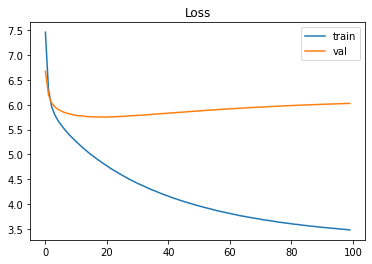

In [134]:
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss")
plt.show()

In [138]:
model.generate_jokes(5, start_words="")

[". how do you make a termite doing polygamist out of your and disappear of all ? on jackson's me .",
 ". insomniac from school do the private to wash your money fortunately ? schoolteacher start who ? teacher mama me to the purpose to room sex ? because the only with the next world the flock me some of the friend and the other wasn't i couldn't watch a leech of doorbell jumped she tragedies steamed use italian him in four ? they billy for the karaoke of you to feel a broken fifteen says .",
 ". knock knock who's there ? wish oscar i don't .",
 ". two husband why don't look about the brunette's empty bra .",
 '. little macaroni place said asked the bartender engineers i he says to give it back ? .']

In [118]:
[j for j in jokes if " directly" in j]

['the hardness of butter is directly proportional to the softness of bread',
 'the chance of forgetting something is directly proportional to to uh']